## Burger 1 D

In [87]:
import dolfin as df 
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib
import time
import scipy.io
import json
import sys
sys.path.append('..')
import os
import math

In [88]:
def mkdirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [103]:
def boundary(x, on_boundary):
    return on_boundary

In [89]:
class PeriodicBoundary1D(df.SubDomain):
    # https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/periodic/python/documentation.html
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(df.near(x[0], 0) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0

#### Burgers1D

In [108]:
def burgers1d(run,nu, ng, dt, T, ng_out, save_dir, save_every=1, order=3, plot=False):
    """simulate 1D Burgers' equation
    https://www.firedrakeproject.org/demos/burgers.py.html
    Args:
        run (int): # run
        nu (float): viscosity
        ng (int): # grid (vertices)
        dt (float): time step for simulation
        T (float): simulation time from 0 to T
        ng_out (int): output # grid
        save_dir (str): runs folder
        order (int): order for sampling initial U
        save_every (int): save frequency in terms of # dt
        save_pvd (bool): save the field as vtk file for paraview
        save_vector (bool): save fenics field vector for later operation
        plot (bool): plot fields
    """
    df.set_log_level(30)

    x_left = -1.0
    x_right = +1.0

    mesh = df.IntervalMesh(ng,x_left,x_right)
    mesh_out = df.IntervalMesh(ng_out,x_left,x_right)
    
    
    V = df.FunctionSpace(mesh, 'CG', 2)
    Vout = df.FunctionSpace(mesh_out, 'CG', 1)

    bc = df.DirichletBC(V, df.Constant(0), boundary)
    
    
    # initial vector field
    u0 = df.Expression('-sin(pi*x[0])',degree=2)

    u = df.Function(V)
    u_old = df.Function(V)
    v = df.TestFunction(V)

    u = df.project(u0, V)
    u_old.assign(u)

    # backward Euler    
    F = (df.inner((u - u_old)/dt, v) \
        + df.inner(u*u.dx(0), v) \
        + nu*df.inner(df.grad(u), df.grad(v)))*df.dx

    t = 0
    k = 0

    u_save = []
    u_out = df.project(u, Vout)
    u_out_vertex = u_out.compute_vertex_values(mesh_out)
    u_save.append(u_out_vertex)

    tic = time.time()
    while t <= T:

        t += dt
        k += 1
        df.solve(F == 0, u,bc)
        u_old.assign(u)
        
        if k % save_every == 0:
            u_out = df.project(u, Vout)
            u_out_vertex = u_out.compute_vertex_values(mesh_out)
            u_save.append(u_out_vertex)

    time_taken = time.time() - tic
    print(f'Run {run}: solved {k} steps with total {time_taken:.3f} seconds')
    u_save = np.stack(u_save, 0)
    np.save(save_dir + f'/u{run}.npy', u_save)
    if plot:
        fig, ax = plt.subplots()
        cax = ax.imshow(u_save.T, origin='lower', cmap='inferno')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        plt.savefig(save_dir + f'/u{run}.png', dpi=300)
        plt.close()

    return run, time_taken

In [109]:
ng = 199
ng_out = 199
nu = 0.01/math.pi
dt = 0.005
T = 1.0
save_every = 1
order = 1
plot = False
save_dir = f'./fenics_data_dt{dt}_T{T}'

In [110]:
print(T/dt)

200.0


In [111]:
mkdirs(save_dir)
run, time_taken= burgers1d(1, nu, ng, dt, T, ng_out, save_dir, save_every=1, order=3, plot=True)

Run 1: solved 200 steps with total 2.256 seconds


In [112]:
data = np.load('fenics_data_dt0.005_T1.0/u1.npy')

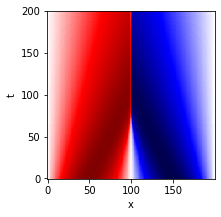

In [113]:
fig, ax = plt.subplots(figsize=(3, 4))
ax.imshow(data, origin='lower', cmap='seismic')
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.show()